# Обрезка


Цель этой работы - практическая реализация механизма обрезки (pruning) примитивной нейронной сети для сокращения ее размера и внутренней задержки прохождения сигнала.

Для этого последовательное разберем следующие этапы:

1.  Базовые концепты механизма обрезки;
2.  Имплементация канальной обрезки;
3.  Понимание базовых концепций улучшения производительности моделей;
4.  Понимание различий между подходами к обрезке.



## Содержание

Работа разделена на две части:

1. Точечная обрезка;
2. Канальная обрезка.

Для выполнения работы потребуется ответить на вопросы и заполнить недостающие участки кода.

---

> Термин "обрезка" (или "прореживание") не вляется устовшимся (в данном случае это просто контекстный перевод), но в этой работе для общего понимания будем использовать эти варианты.

# Настройка

Установите необходимые пакеты, загрузите наборы данных и предварительно обученную модель. Здесь мы используем набор данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) и сеть [VGG](https://arxiv.org/pdf/1409.1556v6.pdf).

Torchprofile - это профилировщик для подсчета количества MAC/FLOPs моделей PyTorch на основе torch.jit.trace.

In [2]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [3]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

#assert torch.cuda.is_available(), \
#"The current runtime does not have CUDA support." \
#"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [5]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [6]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [7]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # переносим на гпу
    inputs = inputs.cuda()
    targets = targets.cuda()

    # зануляем грудиенты
    optimizer.zero_grad()

    # прямой проход
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # обратное распространение
    loss.backward()

    # обновляем оптимизатор и планировщик скорости обучения
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [8]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # отправляем данные на ГПУ
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Инференс
    outputs = model(inputs)

    # конвертируем логиты в индексы классов
    outputs = outputs.argmax(dim=1)

    # обновляем метрики
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Вспомогательные функции (вычисление Flops, Model Size etc.)

In [9]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:

    ##  вычисление разреженности тензора
    ##  sparsity = #zeros / #elements = 1 - #nonzeros / #elements

    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:

    ##  вычисление параметра разреженности модели
    ##  sparsity = #zeros / #elements = 1 - #nonzeros / #elements

    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:

    ##  вычисление общего числа параметров модели
    ##  :param count_nonzero_only: подсчет только ненулевых весов

    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:

    ##  вычисление размера модели в битах
    ##  :param data_width: #bits per element
    ##  :param count_nonzero_only: подсчет только ненулевых весов

    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Функционал для проверки.

In [10]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Загружаем предобученную модель и датасет.

In [11]:
checkpoint_url = "https://cloud.tpu.ru/index.php/s/SdEXQPKgH6aFJG8/download/vgg.cifar.pretrained.pth"

checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

Downloading: "https://cloud.tpu.ru/index.php/s/SdEXQPKgH6aFJG8/download/vgg.cifar.pretrained.pth" to ./vgg.cifar.pretrained.pth
<ipython-input-11-8635f08504ef>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rela

=> loading checkpoint 'https://cloud.tpu.ru/index.php/s/SdEXQPKgH6aFJG8/download/vgg.cifar.pretrained.pth'


In [12]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

100%|██████████| 170M/170M [00:03<00:00, 50.3MB/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


Визуализируем несколько изображений в наборе данных и соответствующие им метки классов:

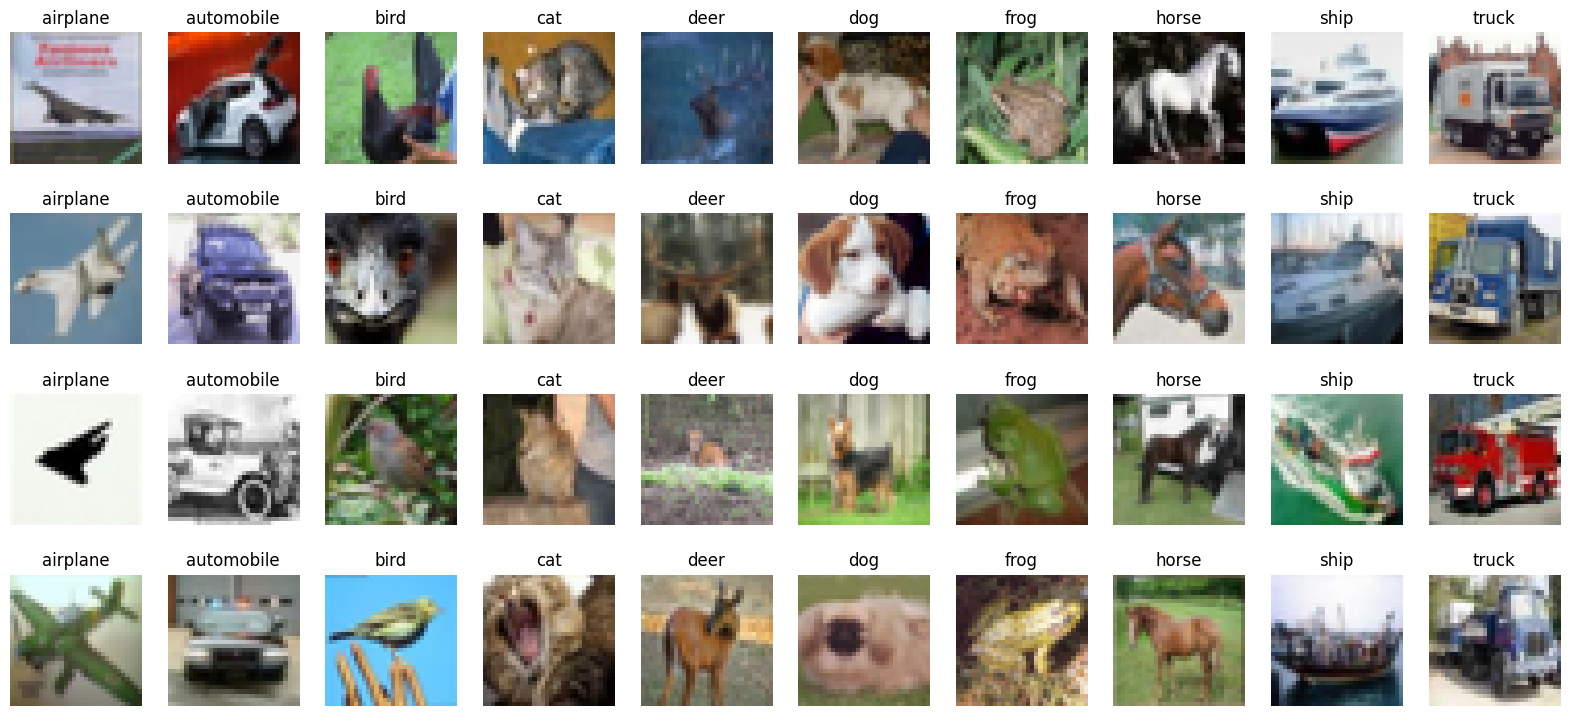

In [13]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]


  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

# Точность и размер



Для начала оценим точность и размер этой модели.

In [14]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


Хотя большие нейронные сети очень мощные, их размер требует значительного объема, пропускной способности памяти и вычислительных ресурсов.

Как мы видим из приведенных выше результатов, модель для такой простой задачи, как классификация изображений $32\times32$ на 10 классов, может иметь размер до 35 МБ.

Для встроенных мобильных приложений эти требования к ресурсам становятся непомерно высокими.

Таким образом, обрезка нейронных сетей используется для облегчения хранения и передачи мобильных приложений, включающих DNN.

Конечной целью всех действий является уменьшение размера модели при сохранении точности.

# Распределение значений весов

Прежде чем мы перейдем к обрезке/прореживанию, посмотрим на распределение значений веса в исходной модели.

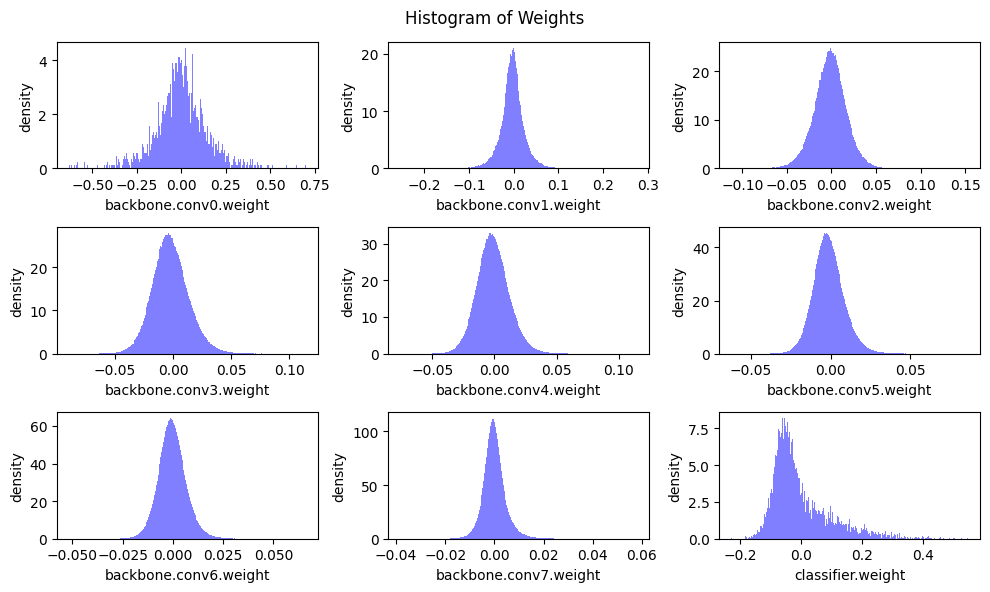

In [15]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

# Часть 1. Точечная обрезка/прореживание

Далее реализуем и выполним точечную обрезку.

При точечной обрезке удаляются синапсы с наименьшей важностью. Тензор веса $W$ станет разреженным, можно описать с помощью:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

где $\#W$ это число элементов в $W$.

На практике, учитывая целевую разреженность $s$, тензор веса $W$ умножается на бинарную маску $M$, чтобы принебречь удаленным весом:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

$Importance$ — тензор важности той же размерности, что и $W$, $\texttt{kthvalue}(X, k)$ находит $k$-ое наименьшее значение тензора $X$, $v_{\mathrm{thr }}$ — пороговое значение.

## Обрезка по магнитуде
В процессе точечной обрезки критерием важности выступает интенсивность (магнитуда) весовых значений, т.е.:

$Importance=|W|$

Метод **Magnitude-based Pruning** (от авторов работы [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

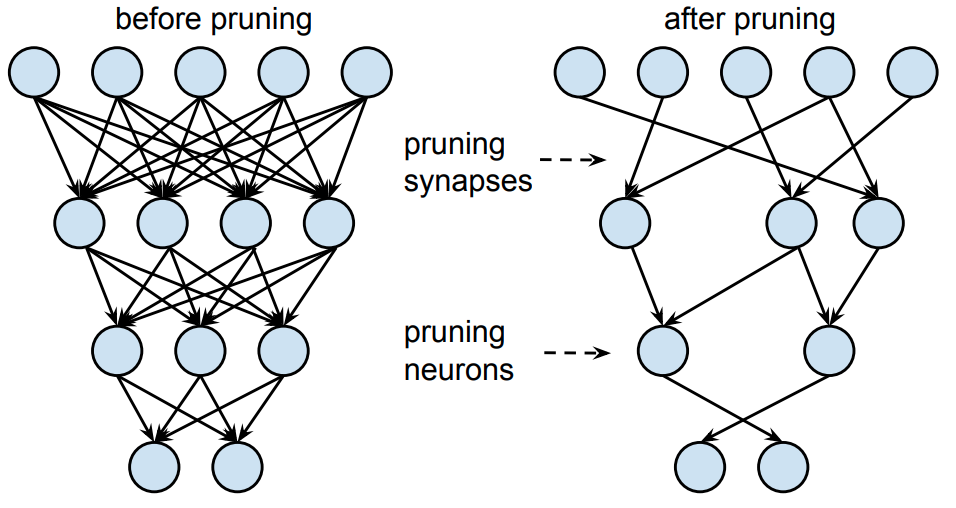

### Задание

Требуется дописать недостающие участки кода в функцию точечной обрезки на основе оценки магнитуды.

Подсказка:

1. мы вычисляем количество нулей (`num_zeros`) после обрезки. Обратите внимание, что `num_zeros` должно быть целочисленным. Вы можете использовать `round()` или `int()` для преобразования плавающего числа в целое число. Здесь мы используем `round()`.

2. вычисляем `importance` тензора веса. Pytorch предоставляет API-интерфейсы [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html).

3. вычисляем порог обрезки, чтобы все синапсы с важностью меньше порога были удалены. Pytorch API [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html),  [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html).

4. вычисляем маску обрезки на основе порога. 1 в маске указывает, что синапс будет сохранен, а 0 - удаляется. `mask = importance > threshold`. Pytorch предоставляет API [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt).






In [19]:
import torch

def fine_grained_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    # обрезка по магнитуде для одного тензора
    #   :param tensor: torch.(cuda.)Tensor, вес conv/fc слоя
    #   :param sparsity: float, разреженность
    #     sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    #   :return:
    #     torch.(cuda.)Tensor, маска зануления

    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: подсчитываем нули
    num_zeros = round(sparsity * num_elements)

    # Step 2: подсчитываем параметр importance для веса
    importance = tensor.abs()

    # Step 3: порог
    if num_zeros > 0:
        # Используем kthvalue для нахождения порога
        threshold = torch.kthvalue(importance.view(-1), num_zeros).values
    else:
        threshold = torch.tensor(0.0, device=tensor.device)

    # Step 4: получаем бинарную маску (1 для ненулевых, 0 для нулевых)
    mask = torch.gt(importance, threshold).type_as(tensor)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: применяем маску
    tensor.mul_(mask)

    return mask

проверим функциональность точечной обрезки, применив приведенную выше функцию к фиктивному тензору.

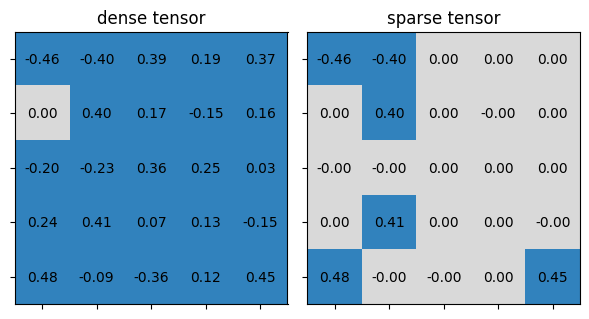

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [20]:
test_fine_grained_prune()

### Задание

Код последней ячейки отображает тензор до и после прореживания. Ненулевые значения отображаются синим цветом, а нули — серым.

Измените значение `target_sparsity` в следующей ячейке кода так, чтобы после обрезки в разреженном тензоре осталось только 10 ненулевых значений.

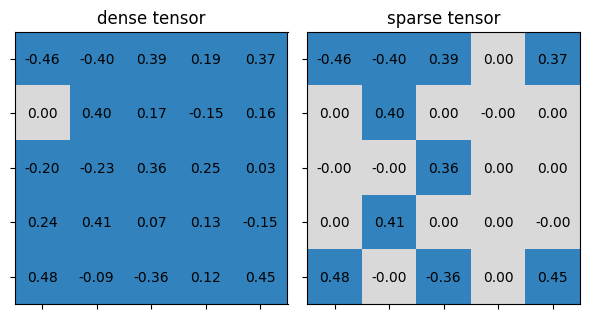

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [21]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = 0.6
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)


Теперь мы обернем функцию точечной обрезки в класс для прогона по всей модели. В классе `FineGrainedPruner` мы будем сохранять маски прореживания, чтобы мы могли применять их при каждом изменении весов модели и гарантировать, что модель все время остается разреженной.

In [22]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # режем только conv и fc веса
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity


Различные слои по-разному влияют на общую производительность модели. Определение требуемой разреженности для каждого слоя нетривиальная задача. В качестве рабочего подхода будем использовать сканирование чувствительности (sensitivity).

Во время сканирования чувствительности каждый раз мы прореживаем только один слой, чтобы отследить снижение точности. Прогоняя различные значения  разреженности, мы можем построить кривую чувствительности (т. е. точности в зависимости от разреженности) соответствующего слоя.

Вот примерный график кривых чувствительности. Ось X — это разреженность или процент отброшенных параметров (т.е. разреженность). Ось Y — валидационная точность.

(Пример на Figure 6 взят из [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))


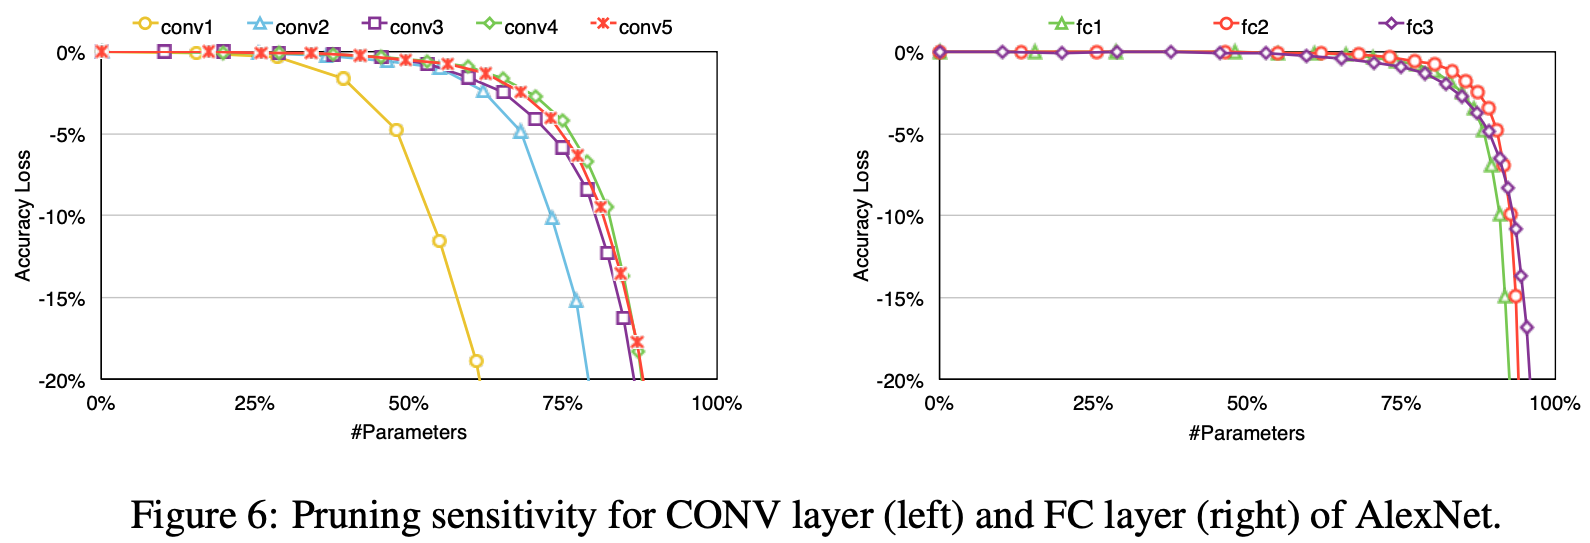


Следующая ячейка кода определяет функцию сканирования чувствительности, которая возвращает разреженности и список по точности для каждого веса, который необходимо отсечь.

In [23]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

Запустите следующие ячейки, чтобы построить кривые чувствительности.
Продолжительность выполнения ячейки ~пару минут.

In [24]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.31%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.87%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.19%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.86%, 92.65%, 92.10%, 90.58%, 83.65%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.92%, 92.88%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.81%, 92.97%, 92.68%, 92.52%]

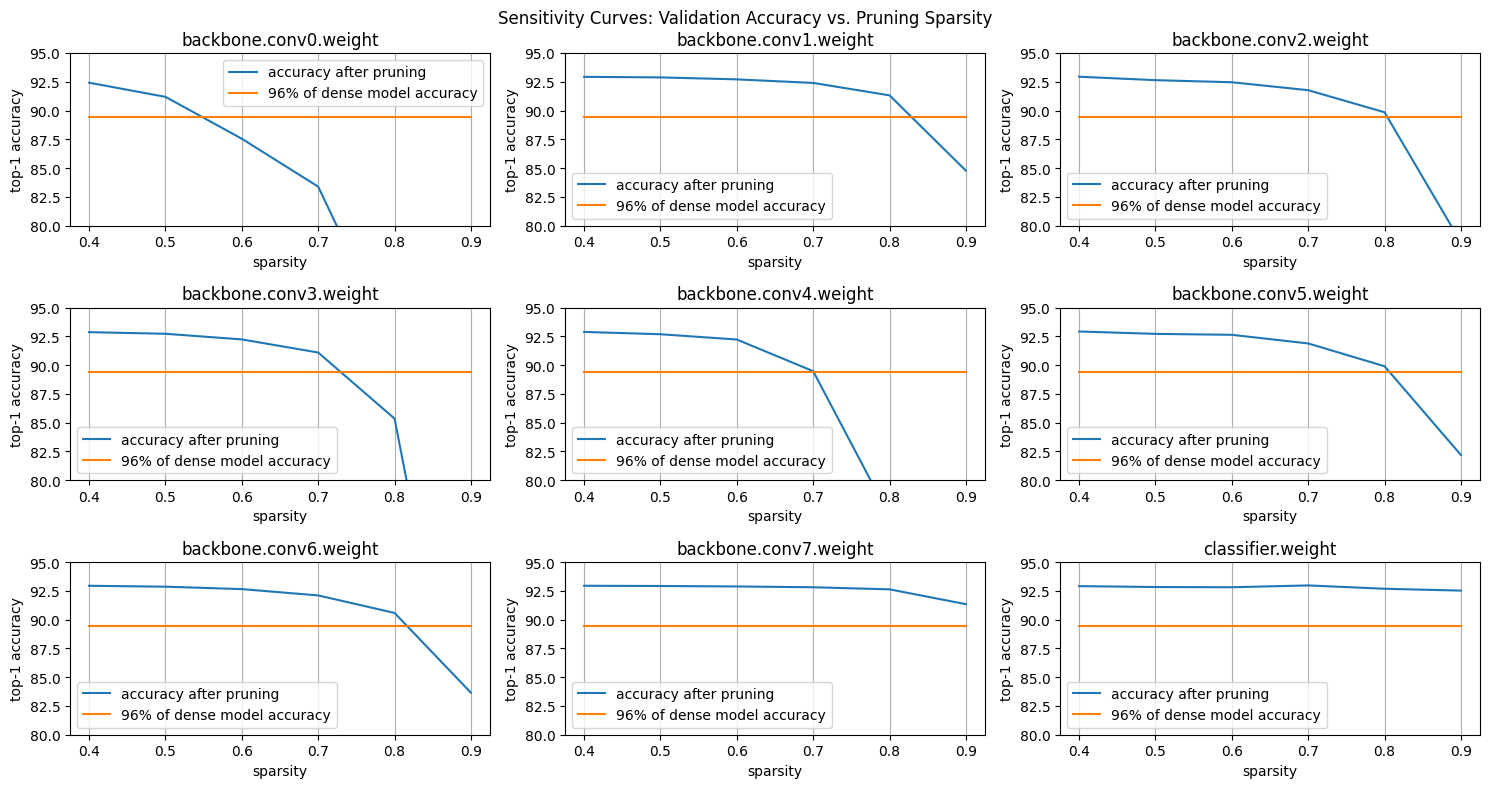

In [26]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

### Вопросы

1. Какова связь между разреженностью и точностью модели? (*т.е.* точность увеличивается или уменьшается, когда разреженность становится выше?)
2. Все ли слои имеют одинаковую чувствительность?
3. Какой слой наиболее чувствителен к обрезке?

## Параметры слоя

Помимо точности, на подбор коэффициента разреженности также влияет количество вычисляемых параметров каждого слоя. Слои с большим количеством требуют большей разреженности.

Построим график распределения параметров по всей модели:

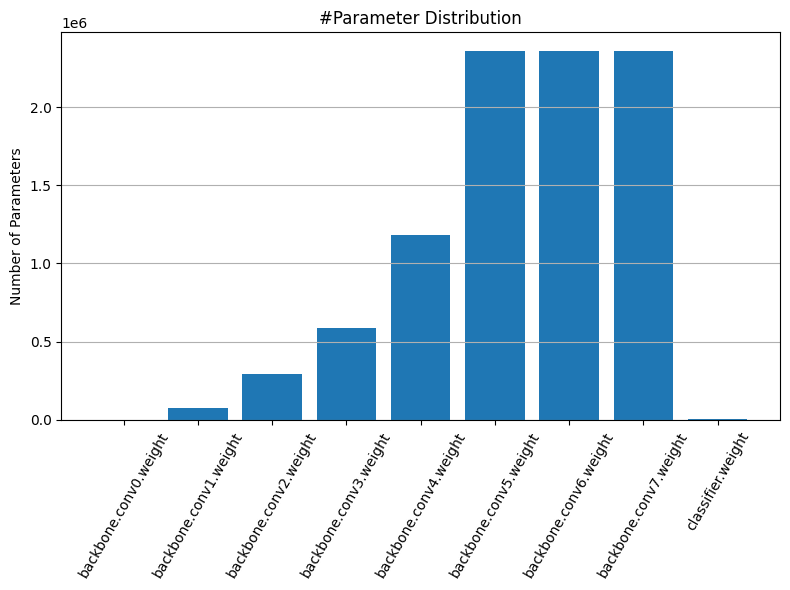

In [27]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Подбор параметра разреженности на основе кривых чувствительности и распределения параметров



### Задание


Основываясь на кривых чувствительности и распределении параметров в модели, подберите разреженность для каждого слоя.

Обратите внимание, что общий коэффициент сжатия модели в основном зависит от слоев с большим количеством параметров, а разные слои имеют разную чувствительность к сокращению.

Убедитесь, что после подгона  разреженная модель составляет примерно 25 % от размера плотной модели, а точность проверки после точной настройки превышает 92,5.

Подсказки:
* Слой с большим количеством параметров должен иметь большую разреженность. (см. график с распределением )
* Слой, чувствительный к сокращению разреженности (т.е. точность быстро падает по мере увеличения разреженности), должен иметь меньшую разреженность. (см. график кривых чувствительности)

In [28]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # укажите значение spatsity для каждого слоя
    # ключи словаря оставить без изменений
    'backbone.conv0.weight': 0,
    'backbone.conv1.weight': 0,
    'backbone.conv2.weight': 0,
    'backbone.conv3.weight': 0,
    'backbone.conv4.weight': 0,
    'backbone.conv5.weight': 0,
    'backbone.conv6.weight': 0,
    'backbone.conv7.weight': 0,
    'classifier.weight': 0
##################### YOUR CODE ENDS HERE #######################
}



Запустите следующую ячейку, чтобы сократить модель в соответствии с заданным  `sparsity_dict`, и вывести информацию о разреженной модели.

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.00
  backbone.conv1.weight: 0.00
  backbone.conv2.weight: 0.00
  backbone.conv3.weight: 0.00
  backbone.conv4.weight: 0.00
  backbone.conv5.weight: 0.00
  backbone.conv6.weight: 0.00
  backbone.conv7.weight: 0.00
  classifier.weight: 0.00
The sparsity of each layer becomes
  backbone.conv0.weight: 0.00
  backbone.conv1.weight: 0.00
  backbone.conv2.weight: 0.00
  backbone.conv3.weight: 0.00
  backbone.conv4.weight: 0.00
  backbone.conv5.weight: 0.00
  backbone.conv6.weight: 0.00
  backbone.conv7.weight: 0.00
  classifier.weight: 0.00
Sparse model has size=35.20 MiB = 100.00% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.95% before fintuning


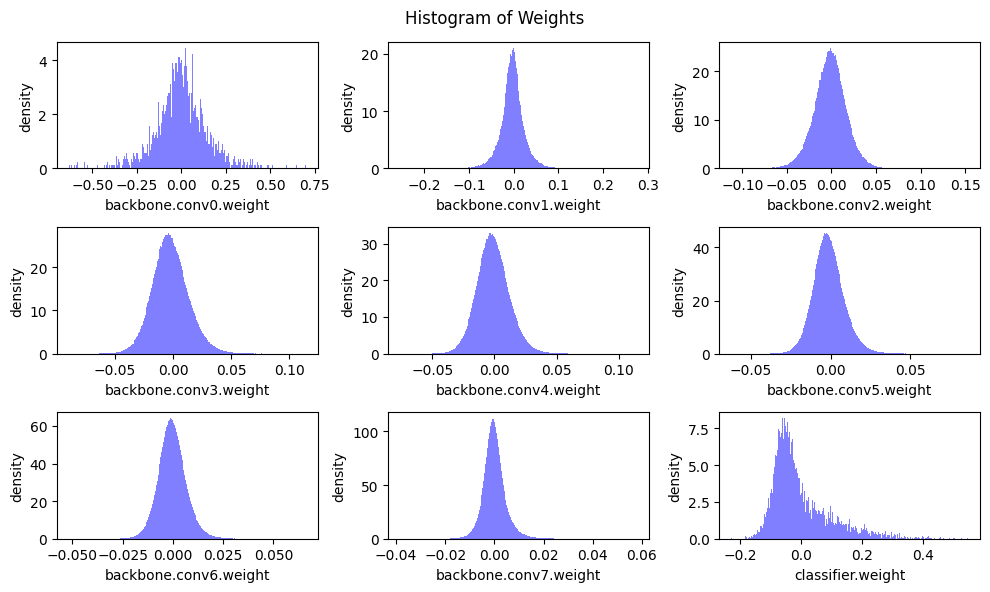

In [29]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

## Дообучение модели


Как мы видим из результатов предыдущей ячейки, хотя точечное обрезка сокращает большую часть весов, точность модели также соответсвенно снижается. Поэтому необходимо дообучить разреженную модель, чтобы восстановить точность.


In [30]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):

    # в конце каждой итерации обучения наложим маску прореживания
    # чтобы сохранять степень разреженности в течении процесса обучения

    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.96% / Best Accuracy: 92.96%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.96% / Best Accuracy: 92.96%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.91% / Best Accuracy: 92.96%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.94% / Best Accuracy: 92.96%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.85% / Best Accuracy: 92.96%


Запустите следующую ячейку, чтобы вывести информацию о лучшей дообученной модели.

In [31]:
# загружаем чекпоинт лучшей модели и считаем итоговую точность
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=35.20 MiB = 100.00% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.96% after fintuning


# Часть 2. Обрезка по каналам



В этой части работы мы реализуем обрезку каналов. В данном способе удаляется весь канал, что позволяет повысить скорость инференса на текущем устройстве.

Аналогично предыдущему подходу удаляем каналы, веса которых имеют меньшую магнитуду (по норме Форбениуса).

In [32]:

# вернем исходные веса модели в первоначальное "плотное" состояние
# и проверим валидационную точность

recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%


## Удаление весов канала

В отличие от точечноой обрезки, мы можем полностью удалить веса из тензора. Т.е. буквально сокращая количество выходных каналов:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Тензор весов $W$ остаётся плотным после обрезки каналов. Таким образом, мы будем называть *разреженность*(`sparsity`) ***коэффициентом обрезки*** (`prune ratio`).


Подобно точечной обрезке, мы можем использовать разные коэффициенты для разных слоев. Однако на данный момент мы используем одинаковое значение для всех слоев.

Текущая задача - двукратное сокращение вычислений, что эквивалентно примерно 30%
обрезке.

Можно протестировать разные коэффициенты обрезки дл каждого слоя в конце этого раздела. (как вариант, передать список коэффициентов в функцию `channel_prune`).




### Задание

Дописать функции для сокращения каналов.
Здесь в упрощенном виде будем отсекать все выходные каналы, кроме первых $\#\mathrm{out\_channels}_{\mathrm{new}}$

In [37]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    # Функция подсчета числа слоев, которые требуется сохранить
    # в своем текущем состоянии после обрезки
    # preserve_rate = 1. - prune_ratio

    ##################### YOUR CODE STARTS HERE #####################
    # Вычисляем количество каналов, которые нужно сохранить
    return int(round(channels * (1.0 - prune_ratio)))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    #
    # Применение канальной обрезки к каждому сверточному слою в используемой модели
    # Для параметра prune_ratio мы можем указать число с плавающей запятой, указывая,
    # что мы используем одинаковый коэффициент обрезки
    # для всех слоев или список, обозначающих скорость обрезки для каждого слоя.

    # проверка работоспособности в соответствии с использованным prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])

    # для коэффициентов механизм такой:  воздействует на выход предыдущего
    # conv слоя и на вход следующего conv. т.е. conv0 - ratio0 - conv1 - ratio1-...

    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # прореживаем по сверткам в исходной модели с одинаковым коэффициентом
    model = copy.deepcopy(model)  # предотвращаем перезапись

    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]

    # прореживаем, сохраняем первые k каналов
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # также как next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # режем выход с предыдущих conv и bn слоев
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # режем вход следующего conv (hint: одной строкой)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    return model


Проверим работоспособность и убедимся в правильности реализации.

In [38]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

* Check passed. Right MACs for the pruned model.



Теперь оценим производительность модели после удаления 30% каналов.


In [39]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%


## Ранжирование каналов по степени важности

Удаление первых 30% каналов по всем слоям приводит к существенному сокращению точности. Потенциальный способ решения этой проблемы — найти **менее важные** каналоы весов, которые нужно удалить. Популярным критерием важности является использование нормы Фробениуса для весов, соответствующих каждому входному каналу:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$


Мы можем отсортировать каналы весов от более важного к менее, и соответсвенно сохранить первые $k$ каналов для каждого слоя.

### Задание


Допишите недостающие части функции для сортировки весового тензора на основе применения нормы Форбениуса

**Подсказка**:
* Для вычисления нормы Форбениуса для тензора можно воспользоваться средствами пайторча: [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm).

In [40]:
# Функция сортировки каналов по степени важности
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # считаем importance по каждому входному каналу
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        # Вычисляем норму Фробениуса для каждого канала
        importance = torch.norm(channel_weight, p='fro')
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # не трогаем оригинальную исходную модель
    # ,берем все conv и bn слои из исходника
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # итерируем по всем conv слоям
    for i_conv in range(len(all_convs) - 1):

        # индекс сортировки каждого канала, нам нужно применить его к:
        # - размерность выхода предыдущего conv слоя
        # - предыдущий слой BN
        # - входная размерность следующего conv (здесь мы вычисляем параметр importance)

        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # отметим что мы вседа вычисляем параметр importance в соответствии с входными каналами
        importance = get_input_channel_importance(next_conv.weight)
        # сортируем по степени важности от большего к меньшему
        sort_idx = torch.argsort(importance, descending=True)

        # применяем к предыдущему conv и следующему за ним bn слою
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # применим к next conv входу (всего одна строка)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

Выполним следующую ячейку, чтобы проверить корректность результата.

In [41]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# здесь мы должны убедиться что точчность не поменялась после сортировки
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=92.95%
* Check passed.




---


Сравним точность прореженной модели с сортировкой и без нее.

In [42]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.14%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=36.81%




Как можно заметить, сортировка каналов немного улучшает точность прореженной модели, но общая точность все еще является неприемлемой. Это типичный результат после применения канальной обрезки. И в этом случае нам требуется снова дообучить модель чтобы попытаться восстановить эффективность.

In [43]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 91.55% / Best Accuracy: 91.55%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 91.97% / Best Accuracy: 91.97%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 92.01% / Best Accuracy: 92.01%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 92.19% / Best Accuracy: 92.19%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 92.29% / Best Accuracy: 92.29%


## Замеры степени ускорения после всех шагов

После дообучения модель практически полностью восстановить исходную точность.
Как уже было обозначено после канальной обрезки обычно чуть сложнее восстановить исходную эффективность в сравнении с точечной. Тем не менее, более показателен результат по размеру и, соответственно, меньшим вычислительным затратам. Далее сравним размер модели, объем выч. затрат и задержку сигнала сокращенной модели.

In [44]:
# вспомогательные функции замера задержки для типовых пайторч моделей

# в отличии от точечной обрезки, канальная может напрямую
# сократить размер модели и ускорить инференс

@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. замеряем задержку исходной модели и сокращенной на ЦПУ
# имитируя инференс на внешнем устройстве
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. считаем (MAC)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. считаем размер модели
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# 4. отправляем назад на девайс
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    26.6            12.9            2.1            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            


## Вопросы по разделу


1. Объясните почему удаление 30% каналов приводит к 50% сокращению выч. затрат?

Квадратичная зависимость

Выч = C(in) * C(out)×Размер ядра×Размер выхода.

2. Объясните, почему коэф. сокращения задержки меньше сокращения коэф. вычислений?

---

## Общие вопросы


1. Каковы преимущества и недостатки точечной обрезки и обрезки каналов?

2. Что можно сказать относительно степени сжатия, точности, задержки, аппаратной поддержки (*т. е.* необходимости использования специального аппаратного ускорителя) и т.д.

3. Если вы хотите, чтобы ваша модель работала на смартфоне быстрее, какой метод обрезки будете использовать? Почему?